# Week 8 Lab

In [1]:
%pylab inline

from sympy import *
init_printing(use_unicode = True, fontsize = 16)

pi2 = pi * 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import sys 

if os.name == 'nt':
    path = 'C:\\Users\\Wei\\Dropbox\\Coding\\notebooks\\專案\\待處理\\Waves\\bitbucket\\github\\codes'
else:
    path = '/home/wei/Dropbox/Coding/notebooks/專案/待處理/Waves/bitbucket/github/codes'
    
sys.path.append(path)
 
from thinkx import * 
from waves.sound import * 
from waves.tools.dsp import * 
from waves.tools.dsp.sampling import * 

## Signal of the Day: Moire Patterns
$$
\begin{align}
x[n] &= cos(\omega_1 n) + cos(\omega_2 n) \\
&= 2cos(\frac{\omega_1-\omega_2}{2} n )cos(\frac{\omega_1+\omega_2}{2} n ) \\
&\approx 2cos(\Delta_\omega n) cos( \omega_1  n ) \\
\end{align}
$$

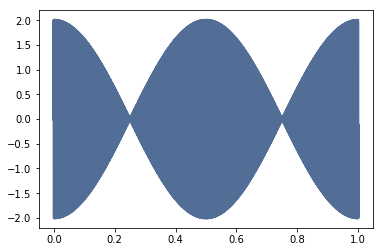

In [3]:
f1 = 440
f2 = f1 + 2
s1 = thinkdsp.SinSignal(f1)
s2 = thinkdsp.SinSignal(f2)
ss = thinkdsp.SumSignal(s1, s2)
w = ss.make_wave(framerate = DEFAULT_FRAMERATE)
w.plot()

### Moire and Aliasing: 1D example

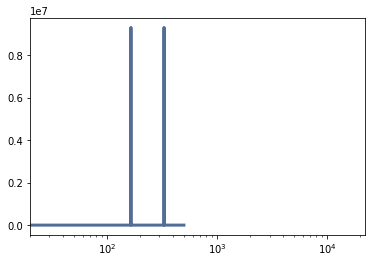

In [4]:
f1 = 165
f2 = f1 * 2
s1 = thinkdsp.SinSignal(f1)
s2 = thinkdsp.SinSignal(f2)
ss = thinkdsp.SumSignal(s1, s2)
w = ss.make_wave(framerate = 1000)
ch = Channel.load_thinkdsp_wave(w)
ch.make_spectrum().plot()

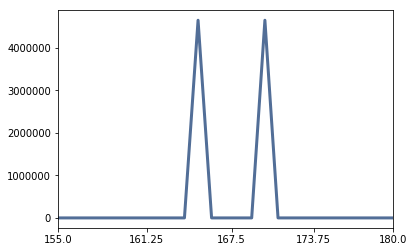

In [5]:
ys = w.ys[::2]
ch = Channel(ys, framerate= 500)  # down sample and the hight frequency will fold back to form beating.
ch.make_spectrum().plot()
xticks = np.linspace(155, 180, 5)
plt.xlim((155, 180))
plt.xticks(xticks, xticks);

In [6]:
tb = ch.make_spectrum()
tb.rank_by_amps()[0][:2]

array([165., 170.])

## 6.2.a Upsampling

To upsample a sequence by a factor of KK, we can implement this in the digital-domain by

- inserting $K-1$ zeros between consecutive samples
- filtering the result with an ideal lowpass filter with cutoff frequency $\frac{\pi}{K} $  

This produces exactly the same result as the operation via the continuous-time domain. Moreover, to recover the original sequence from the up sampled one, we can simply discard all coefficients that are not integer multiple of K.

眾多以n $(n \in \mathbb{Z})$ 為中心的sinc波形 $sinc(\frac{t}{Ts} -n)$ 形成 Hilbert space 的一組 basis  


#### Analysis (sampling) formula:  
$$x[n] = <x(t), sinc(\frac{t}{Ts} -n)> = Ts \times x(nTs)$$  

#### Synthesis (reconstruction) formula:  
$$x(t) = \frac{1}{Ts}\sum_{n= -\infty}^{\infty} x[n] sinc(\frac{t}{Ts} -n)$$  


#### Re-sampling (operation via the continuous-time domain):  

$$
\begin{align}
x[m] &= original \space descrete \space signal \\
Ts & = interpolation (sampling) \space interval \\ 
x_c(t) &= \frac{1}{Ts} \sum_{m = -\infty}^{\infty} x[m]sinc(\frac{t}{Ts} - m) \\
resample \space interval &=   \frac{Ts}{K} \\ 
x^{\prime}[n] = x_c(n \frac{Ts}{K}) &=\frac{1}{Ts}   \sum_{m = -\infty}^{\infty} x[m]sinc(\frac{n \frac{Ts}{K}}{Ts} - m) \\
&=  \frac{1}{Ts} \sum_{m= -\infty}^{\infty} x[m] sinc(\frac{n }{K } - m) & ------(1) \\
\end{align}
$$

- 由 $x[n]$ 做 Interpolation 成為 $x(t)$, 和由 $x[n]$ 做 re-sampling 成為 $x^{\prime}[n]$ 都是一種 interpolation 的過程。
- 以 K 倍率做 re-sampling，相當於把 原本的 x[m] 對以$\frac{n }{K }$為中心的$ sinc()$ function 做 convolution
- resampling 可視為一種 convolution 的動作
- 既然等同於 convolution，那麼就可以用 FIR filter 來達到 resampling 的效果
- 取樣的 Ts 變小，相當於 $\Omega_N $變大
- Ts 變成 1/K，表示時間上的解析度變高，可以表達的頻率範圍變大，$\Omega_N$ 變成 K 倍
- Ts 變成 1/K，但原本訊號 x 的時間總長並不變，所以雖然經過 re-sampling 所含的頻率 (Hz) 並不變，但是 $\Omega_N$ 已經變成 K 倍。
- 當 resample 之後，離散訊號中所代表的 frequency 不變，但是頻率範圍會由 $\Omega_N$ 變成 $\pi$。
- K的倍數越大，相當於原本訊號被壓縮到更小的離散頻率範圍。
- re-sampling 之後的 $x^{\prime}[n]$ 是一個 descrete time signal，所代表的頻率範圍是 $-\pi \to \pi$，所以是經過 K倍壓縮的。
  - $\pi \Rightarrow \Omega_N $ ; 離散的 $\pi$ 相當於 $\Omega_N$
  - $\Omega_N   \times  K = K\Omega_N $ ;   $\Omega_N$ 放大 K 倍
  - $K\Omega_N \Rightarrow \pi $ ; K 倍的$\Omega_N$ 相當於 $\pi$，原本的頻譜內容被壓所到一個較小的頻率範圍中。

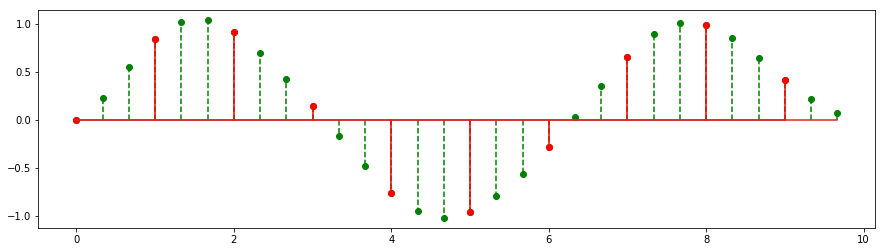

In [7]:
from waves.tools.dsp.interpolator import *


t = np.arange(10)

x = np.sin(t)
K = 3
n, x1 = Multirate.upsample(x, K)

plt.figure(figsize = (15, 4))
plt.stem(n, x1, linefmt = 'g--', markerfmt = 'go')
plt.stem(t, x, linefmt = 'r-', markerfmt = 'ro')
plt.show()

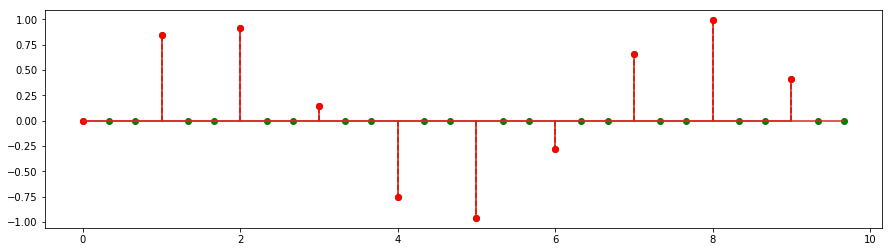

In [8]:
# 使用 EPFL 提供的 multirate.upsample 函數，只會等距插入 K-1 個 0

from waves.tools.dsp.sampling import *


t = np.arange(10)

x = np.sin(t)
K = 3
x1 = multirate.upsample(x, K)

plt.figure(figsize = (15, 4))
plt.stem(np.arange(len(x1))/K,  x1, linefmt = 'g--', markerfmt = 'go')
plt.stem(t, x, linefmt = 'r-', markerfmt = 'ro')
plt.show()

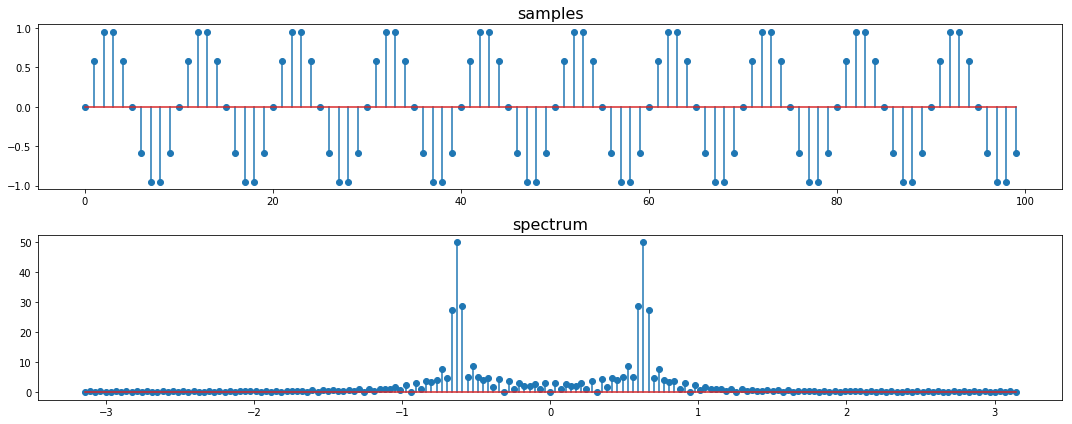

In [9]:
s = thinkdsp.SinSignal(10)
w = s.make_wave(duration = 1, framerate = 100)
YS = fourier.dtft(w.ys)

### up sample 三倍之後：
- 波形看起來一樣，但是 X 軸的長度變為三倍
- 以 descrete 的觀點來看，每一點x之間 y的變化較小，表示表達的能力較強，可以容納與表達的頻率範圍較大
  - 每一點x之間 y的變化較小，表示對於 x軸間隔來說，此訊號的頻率較低
- 對同一個訊號來說，
  - Ts 變小，
  - 做 up sample之後，Ts 變小:
    - $\Omega_N$ 就變大，但是...
    - 做 DTFT 之後 解析出來的頻率範圍還是  $ [-\pi , \pi]$ 
    - 訊號顯得行動緩慢，此訊號的頻率在 $ [-\pi , \pi]$ 範圍中出現的位置會縮小，而往中央靠攏。 
  - 所以做 up sample 會將頻譜壓縮。

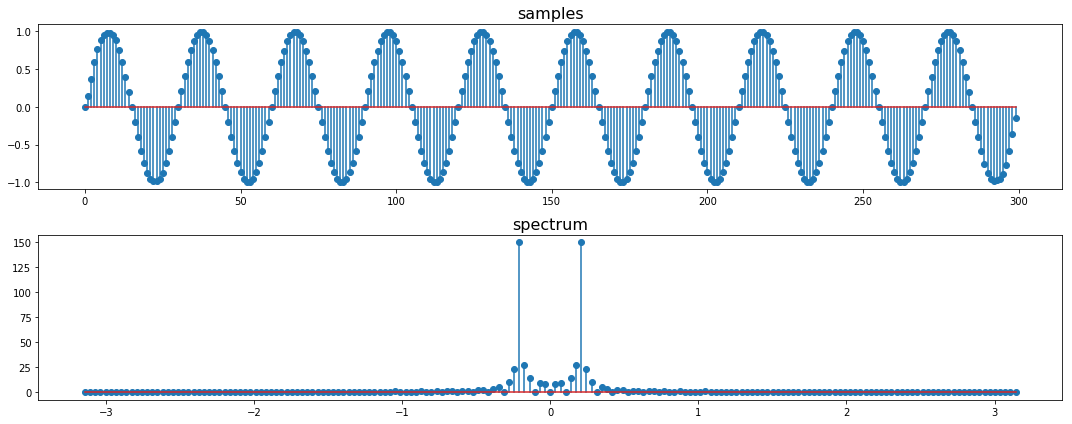

In [10]:
_, ys1 = Multirate.upsample(w.ys, 3)
YS1 = fourier.dtft(ys1)

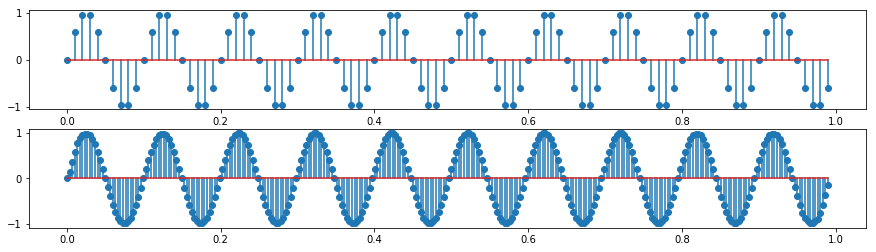

In [11]:
# 測試 scale_t 的功能

plt.figure(figsize = (15, 4))
plt.subplot(2, 1, 1)
plt.stem(w.ts, w.ys)
plt.subplot(2, 1, 2)
plt.stem(Multirate.scale_t(w.ts, K), ys1);  # 測試 scale_t 的功能

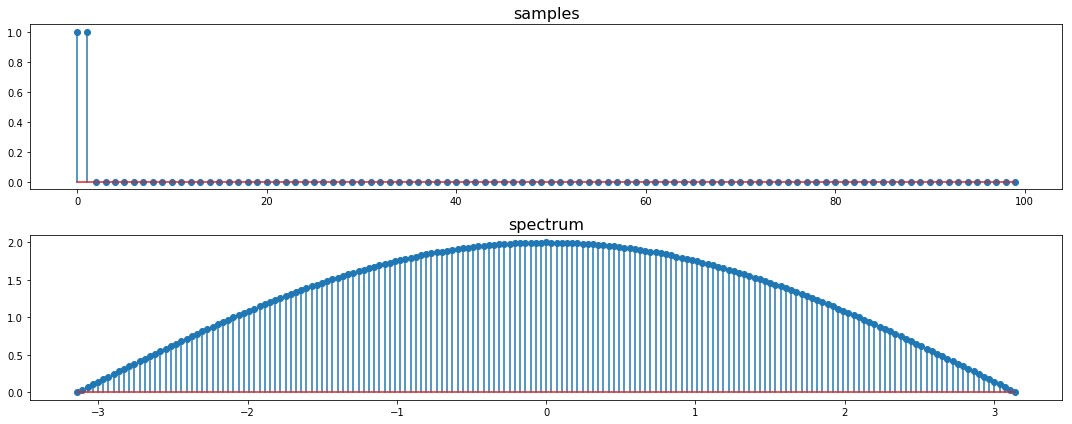

In [12]:
d = np.zeros(100)
d[:2] =1
D = fourier.dtft(d)

### 如果有 interpolate，則只會出現主頻譜

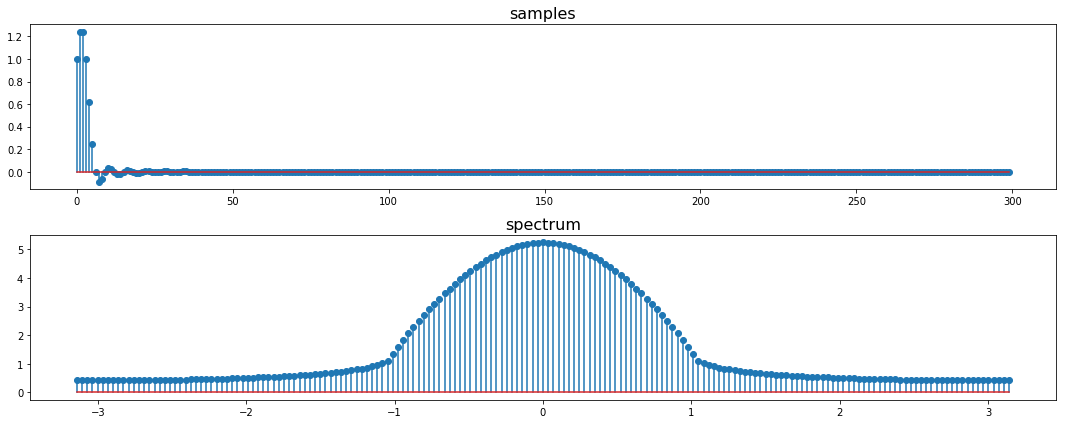

In [13]:
_, d1 = Multirate.upsample(d, 3)
D1 = fourier.dtft(d1)

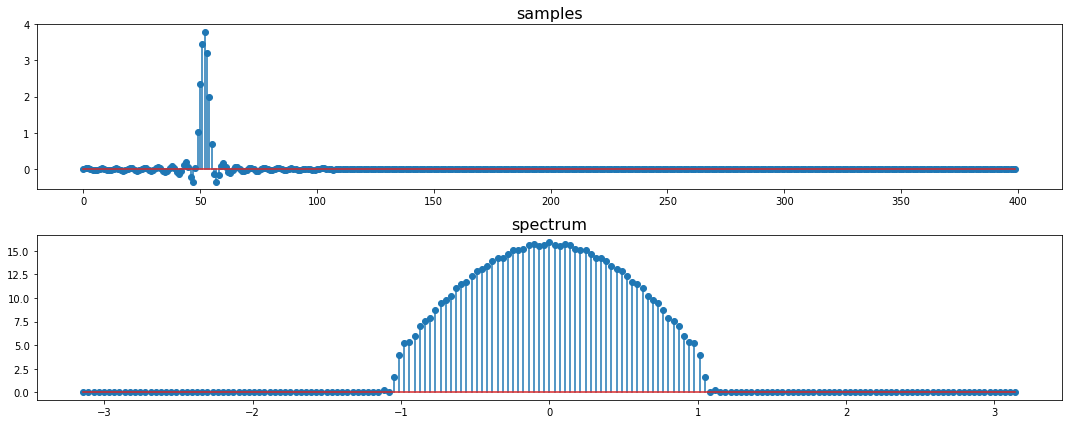

In [14]:
N = len(d) // 2

d2 = np.convolve(d1, np.sinc(np.arange(-N, N+1)/K))
D2 = fourier.dtft(d2)

### 如果只是 插入0做 up sampling，但是沒有 interpolate
- 使用 EPFL 提供的 multirate.upsample 函數，只會等距插入 K-1 個 0
- 則會把 $[-3\pi, 3\pi]$ 範圍內 三倍壓縮成  $[-\pi, \pi]$ ，而出現多個副本頻譜  

$$
\begin{align}
X_U(e^{j\omega}) &= \sum_{m=-\infty}^{\infty} X_U[m] e^{-j\omega m}  &   x_U[m] = 0 \space when \space  m \neq n k  \\
&= \sum_{n=-\infty}^{\infty} X[n] e^{-j\omega nK}  \\
&= X(e^{j\omega K})
\end{align}
$$  

#### 做 K 倍 的 Up sample，其頻譜等於是原來的頻譜作 頻率上的 K 倍壓縮。

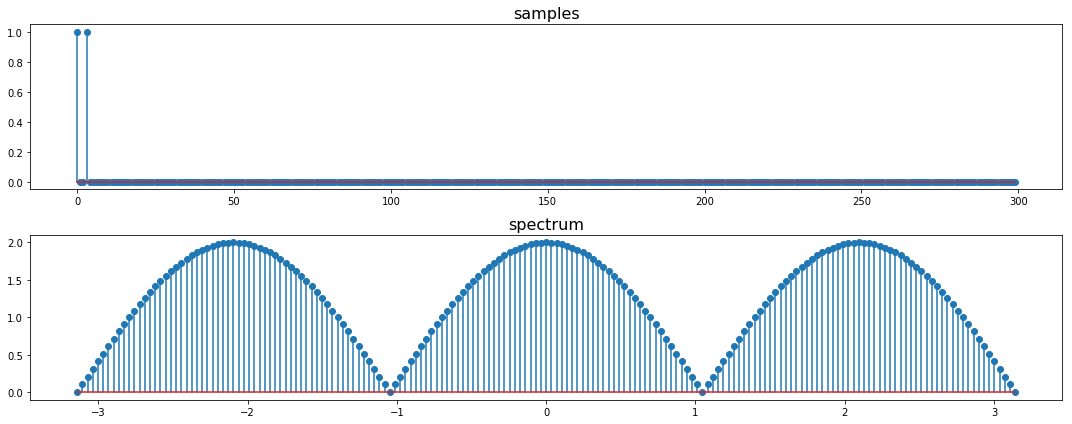

In [15]:
# 使用 EPFL 提供的 multirate.upsample 函數，只會等距插入 K-1 個 0

d1 = multirate.upsample(d, 3)
D1 = fourier.dtft(d1)

### 施加一個 low-pass filter
- 因為 原來做 K=3 的 up sampling
- 現在施以一個 $\omega_{cut} = \frac{\pi}{K}$ 的 low-pass ideal filter
- 等於以 $sinc(\frac{n}{K}) $ 做 convolution，因為 since 的 DTFT 是 rect  

$$
\begin{align}
x^{\prime}[n] &= x_U(n) * sinc(\frac{n}{K})  \\
&= \sum_{i = -\infty}^{\infty} x_U[i] sinc(\frac{n-i}{K})   &   x_U[i] = 0 \space when \space  i \neq m k  \\
&= \sum_{m=-\infty}^{\infty} x[m] sinc(\frac{n}{K} - m)  & ------(2) \\
\end{align}
$$  

公式 (1), (2) 是相同的，所以下述兩者的效果相同:
- 以 $sinc(\frac{n}{K}) $ 對 $x[m]$ 做 convolution 做 up sampling
- 等距插入 k-1 個 0 做 up-sampling 得到 $x_U[n]$ 並以 $sinc(\frac{n}{K}) $ 對 $x_U[n]$ 做 low-pass filtering

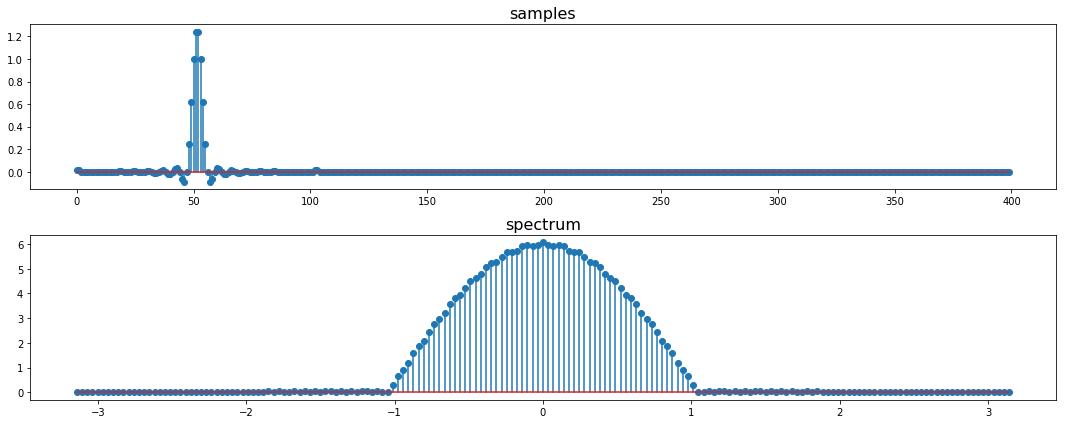

In [16]:
N = len(d) // 2
d2 = np.convolve(d1, np.sinc(np.arange(-N, N+1)/K))  
D2 = fourier.dtft(d2)

C:\Softwares\Python\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


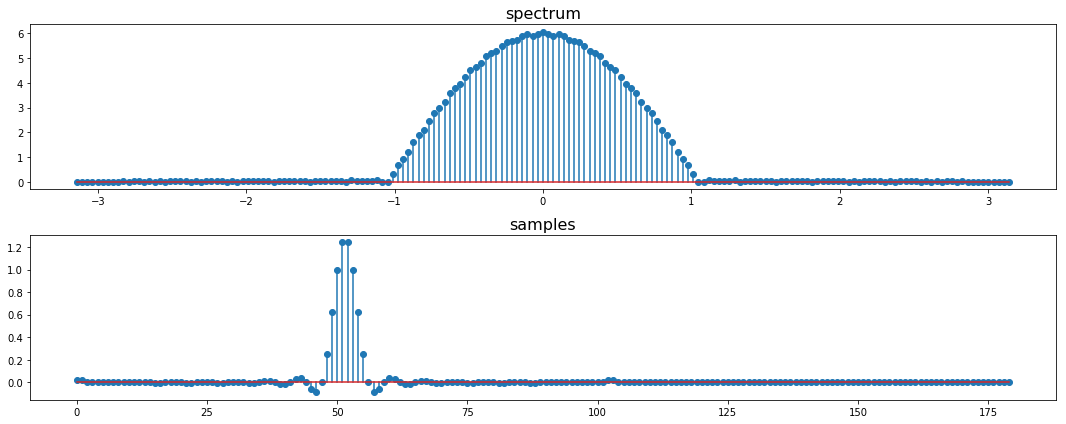

In [17]:
_ = fourier.idtft(D2)

### 所以，只是:
- 等距插入 K-1 個 0 做 K 倍 up sampling 就可將頻譜壓縮，
- 只需要再以  $sinc (\frac{n}{K}) $ 做 convolution 施加 low-pass filter 就可以去除一同被壓縮進來的高頻訊號-

## 6.2.b Fitting the transmitter spectrum
- Given the bandwidth constraint given by $F_{min}$ and $F_{max}$ , 
- let $ W$ be the positive bandwidth $W = F_{max} - F_{min}$ and 
- let us choose the sampling frequency such that $F_s > 2F_{max}$ and
- $F_s = KW$. When we translate this specification in the digital domain, 
- we can simply upsample the original sequence by a factor $K$ to shrink its bandwidth from $2\pi$ to $2\pi/K$. 
- This upsampling operation does not change the data rate and we transmit $W$ symbols per second. 
- $W$, the positive bandwidth of a channel, is referred to as the ***Baud rate*** of the system.

$$
\begin{align}
W &= F_{max} - F_{min}  \\
pick \space F_s &> 2 F_{max}  \\
let \space F_s &= KW  \\
\omega_{max} - \omega_{min} &= 2 \pi \frac{W}{F_s} \\
&= 2\frac{\pi}{K} \\
\end{align}
$$  

Set $F_s = KW$, then we can simply upsample by K.

### Raised Cosine
https://en.wikipedia.org/wiki/Raised-cosine_filter

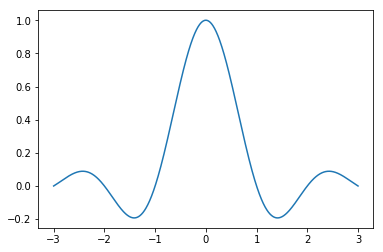

In [18]:
def raised_cosine(t, beta, T):
    h = 1/T*np.sinc(t/T)*np.cos(np.pi*beta*t/T)/(1-(2*beta*t/T)**2)
    idx = np.abs(t) == T/(2*beta)
    h[idx] = np.pi/(4*T) * np.sinc(1/(2*beta))
    return h

t = np.linspace(-3, 3, 1000)
plt.plot(t, raised_cosine(t, beta = 0.25, T = 1));

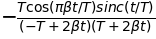

In [19]:
# 用 SymPy 簡化

beta, T, t = symbols('beta, T, t', real = True)

h = Piecewise((pi/(4*T) * sinc(1/(2*beta)), abs(t) == T/(2*beta)), 
              (1/T*sinc(t/T)*cos(pi*beta*t/T)/(1-(2*beta*t/T)**2), True))

h.collect(t).factor()

### 這是以 T (Ts) 為單位的 sinc 函數的變形
- $t = 0$ 的時候，RC 函數的值 = $\frac{T}{T^2} = \frac{1}{T} $
- 每當 t 是 T 的整數倍數的時候，RC = 0

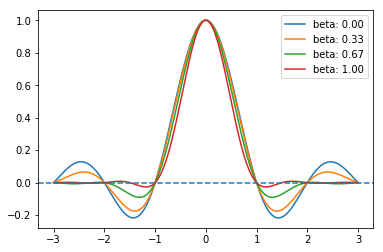

In [20]:
t = np.linspace(-3, 3, 1000)

for b in np.linspace(0, 1, 4):
    plt.plot(t, filtering.raised_cosine(t, period = 1, beta = b), label = 'beta: {:0.2f}'.format(b))
    
plt.axhline(0, ls = '--')
plt.legend();

In [21]:
# 用 SymPy 簡化 h 的頻率響應 H

beta, T, f = symbols('beta, T, f', real = True)

H = Piecewise(( 1/2*(1+cos(pi*T/beta*(abs(f)-(1-beta)/(2*T)))), ((1-beta)/(2*T) < abs(f))  & (abs(f) <= (1+beta)/(2*T)))   ,
              (1, abs(f)<= (1-beta)/(2*T)),(0, True),
              (0, True)) 

H.rewrite(cos).collect(f).factor()

⎧         ⎛π⋅T⋅│f│    π ⎞                   β     1             β     1 
⎪- 0.5⋅sin⎜─────── - ───⎟ + 0.5  for │f│ ≤ ─── + ─── ∧ │f│ > - ─── + ───
⎪         ⎝   β      2⋅β⎠                  2⋅T   2⋅T           2⋅T   2⋅T
⎪                                                                       
⎨                                                      β     1          
⎪              1                          for │f│ ≤ - ─── + ───         
⎪                                                     2⋅T   2⋅T         
⎪                                                                       
⎩              0                                otherwise               

### RC函數的 frequency response 
- 用來做低通濾波的
- 其 cutoff frequency = $\frac{1}{2 T_s} = \frac{\Omega_N}{2\pi}$
  - $ \frac{\pi}{T_s} = \Omega_N   $
  - $ \frac{1}{T_s} = \frac{\Omega_N}{\pi}  $
  - $ \frac{1}{2 T_s} = \frac{\Omega_N}{2\pi} $
- 當 $\beta = 0$ 的時候，f 必須在 $[-\frac{1}{2T_s},\frac{1}{2T_s}]$ 之間 H 才會有大於零(= 1)的值

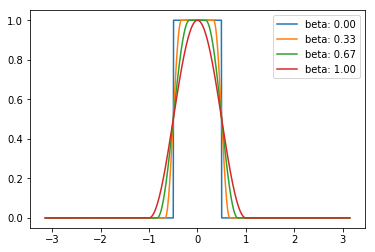

In [22]:
f = np.linspace(-np.pi, np.pi, 1000)
for b in np.linspace(1e-7, 1, 4):
    plt.plot(f, filtering.raised_cosine_response(f, period = 1, beta = b), label = 'beta: {:0.2f}'.format(b))

plt.legend();

### RC filter 的使用方式

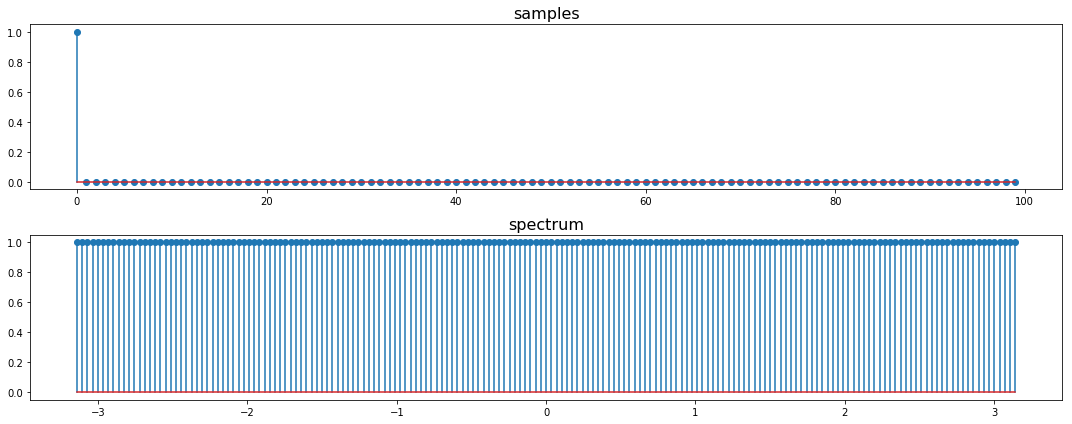

In [23]:
# Delta 訊號，全頻
delta = np.zeros(100)
delta[:1] =1
Delta = fourier.dtft(delta)

### RC 的現象
- RC impulse response 的長度只受到 指定的整數大小(N) 與 整數之間 steps_between 的影響 (N * 2 * steps_between + 1)
- RC impulse response 的長度越長，頻率響應越精確，但是越消耗效能
- 不論 RC impulse response 的長度有多長，其頻率響應都是一樣的，只跟 T (symbol period) 有關，cutoff freq = $\frac{1}{2T}$
- 把 RC 的波形 在 t = K T 的時候 = 0 (RC(KT) = 0，K和K+1中間切分 1/T等分，切得越多，對頻譜壓縮得越多。

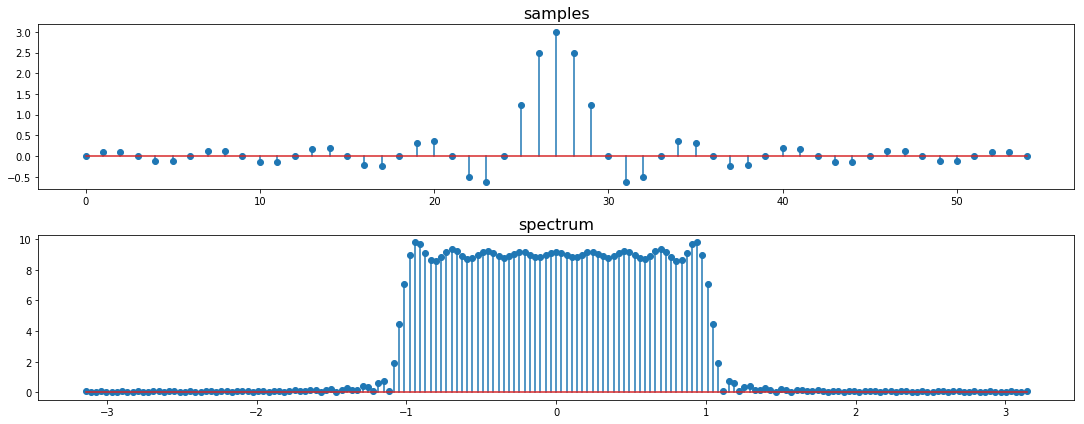

In [24]:
# def raised_cosine_fir(w_c = 1 / 3, fir_size = 51, beta = 0.0):
#     assert fir_size % 2 == 1, 'fir_size should be odd.'
#     N = np.ceil((fir_size - 1) / 2 * w_c)
#     t = np.linspace(-N, N, int(N / w_c) * 2 + 1) * w_c
#     h = filtering.raised_cosine(t, period = w_c, beta = beta)
#     return h

h = filtering.raised_cosine_fir(w_c = 1/3)
H = fourier.dtft(h)

### 將 Delta 濾波，只剩下 $\omega_{N} = \frac{\pi}{3}$ 以內的部分

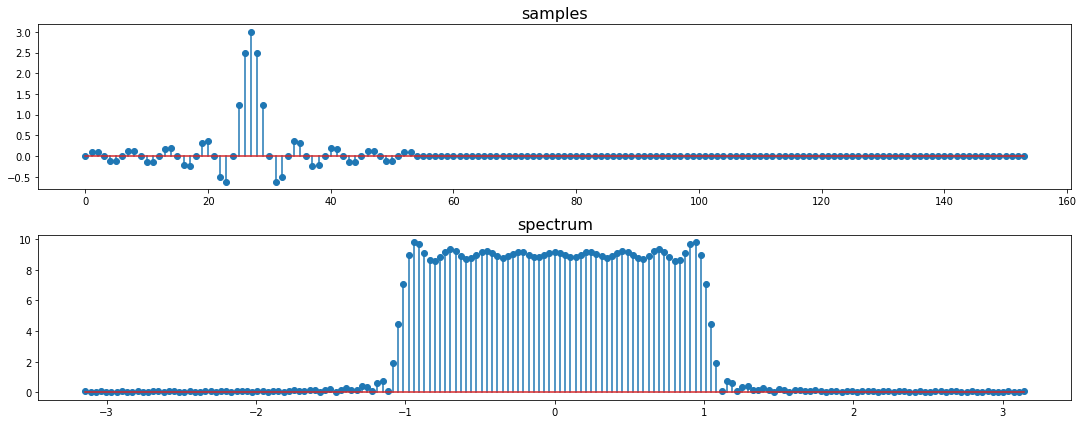

In [25]:
delta1 = np.convolve(delta, filtering.raised_cosine_fir(w_c = 1/3))
Delta1 = fourier.dtft(delta1)

### Fit signal into channel

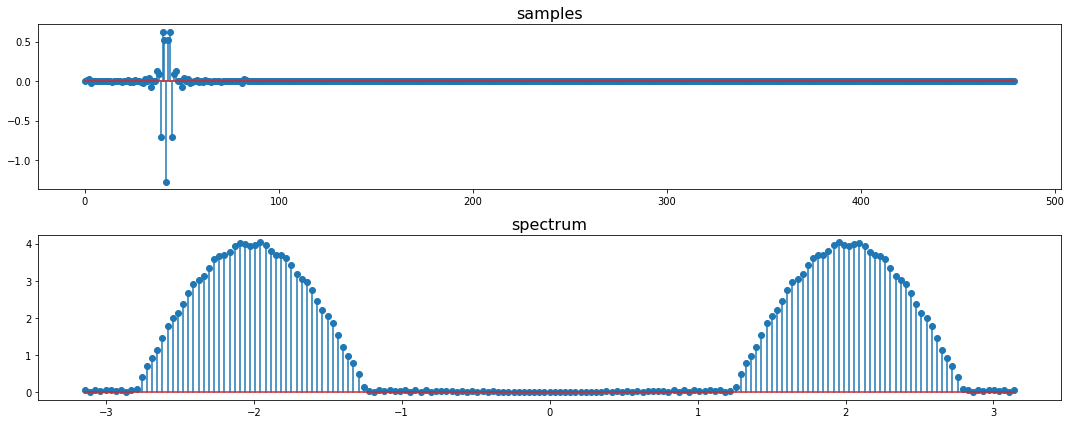

In [27]:
# def fit_spectrum(x, Fmin, Fmax, fir_size = 40, beta = 0.0):
#     W = Fmax - Fmin
#     K = int(np.ceil(2 * Fmax / W))
#     Fs = K * W
#     F_nyquist = Fs / 2

#     w_min = Fmin / F_nyquist * np.pi
#     w_max = Fmax / F_nyquist * np.pi
#     w_c = (w_max - w_min) / 2
#     w_center = (w_min + w_max) / 2

#     # up sample
#     x1 = multirate.upsample(x, K)

#     # low-pass filter
#     # N = len(x) // 2
# #     h = np.sinc(np.arange(-fir_size, fir_size + 1) / K)
#     h = filtering.raised_cosine(np.arange(-fir_size, fir_size + 1) / K, period = np.pi / w_c / K, beta = beta)
#     x1 = np.convolve(x1, h)

#     # modulate to pass bands
#     x1 = np.cos(w_center * np.arange(len(x1))) * x1

#     return K, Fs, w_c, w_center, x1


Fmin = 4400  # channel 允許的頻率下限
Fmax = 10000  # channel 允許的頻率上限

K, Fs, w_c, w_center, x1 = filtering.fit_spectrum(d, Fmin, Fmax) 

_ = fourier.dtft(x1)